## Large Dataset: Big Five Personality Classification

This section applies logistic regression to the Big Five Personality Test dataset, which serves as the large-scale dataset in this project.

In the **first phase**, the model is trained using **standard scikit-learn** without any parallelization to establish a **baseline** performance reference.

In the **second phase**, the dataset is processed using **Apache Spark** with multiple partitioning configurations (e.g., 2 and 4 partitions) to enable parallel execution and analyze how performance scales with increased parallelism.

At the end of each phase, the model is evaluated using **accuracy**, **F1 score**, **training time**, and the **confusion matrix**. This allows us to compare both runtime efficiency and classification quality between the baseline and parallelized Spark approaches on a large dataset.




In [ ]:
!pip install pycountry


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 38.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import geopandas as gpd
import pycountry


In [ ]:
import kagglehub

path = kagglehub.dataset_download("tunguz/big-five-personality-test")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/big-five-personality-test


In [ ]:
import os

inner_path = os.path.join(path, "IPIP-FFM-data-8Nov2018")
print("Files in subfolder:")
print(os.listdir(inner_path))


Files in subfolder:
['codebook.txt', 'data-final.csv', '.directory']


In [ ]:
csv_file = os.path.join(path, "IPIP-FFM-data-8Nov2018", "data-final.csv")
df = pd.read_csv(csv_file, sep="\t")
df.head()


,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,2016-03-03 02:01:01,768.0,1024.0,9.0,234.0,6,1,GB,51.5448,0.1991
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,...,2016-03-03 02:01:20,1360.0,768.0,12.0,179.0,11,1,MY,3.1698,101.706
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,2016-03-03 02:01:56,1366.0,768.0,3.0,186.0,7,1,GB,54.9119,-1.3833
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,...,2016-03-03 02:02:02,1920.0,1200.0,186.0,219.0,7,1,GB,51.75,-1.25
4,3.0,3.0,3.0,3.0,5.0,3.0,3.0,5.0,3.0,4.0,...,2016-03-03 02:02:57,1366.0,768.0,8.0,315.0,17,2,KE,1.0,38.0


In [ ]:
df.describe()


,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN7_E,OPN8_E,OPN9_E,OPN10_E,screenw,screenh,introelapse,testelapse,endelapse,IPC
count,1.013558e+06,1.013558e+06,1.013558e+06,1.013558e+06,1.013558e+06,1.013558e+06,1.013558e+06,1.013558e+06,1.013558e+06,1.013558e+06,...,1.013558e+06,1.013558e+06,1.013558e+06,1.013558e+06,1.013275e+06,1.013275e+06,1.013275e+06,1.013558e+06,1.015341e+06,1.015341e+06
mean,2.648067e+00,2.773115e+00,3.288349e+00,3.140595e+00,3.276960e+00,2.401100e+00,2.771744e+00,3.414818e+00,2.963740e+00,3.556469e+00,...,7.689488e+03,5.423945e+03,6.325802e+03,5.336311e+03,1.149510e+03,8.262611e+02,9.590748e+02,6.754233e+02,2.701410e+03,1.045211e+01
std,1.264407e+00,1.323943e+00,1.215006e+00,1.237442e+00,1.277593e+00,1.225721e+00,1.400336e+00,1.271915e+00,1.346040e+00,1.305232e+00,...,5.841987e+05,2.629748e+05,4.298906e+05,4.408225e+05,5.600884e+02,1.802490e+02,5.104005e+04,2.017864e+04,1.483898e+06,3.982879e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-6.181300e+04,-5.001200e+04,-9.598600e+04,-3.594871e+06,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,...,2.279000e+03,2.144000e+03,2.329000e+03,1.484000e+03,4.140000e+02,7.200000e+02,5.000000e+00,1.710000e+02,9.000000e+00,1.000000e+00
50%,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,...,3.208000e+03,3.051000e+03,3.269000e+03,2.192000e+03,1.366000e+03,7.680000e+02,1.000000e+01,2.240000e+02,1.300000e+01,1.000000e+00
75%,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00,...,4.729000e+03,4.469000e+03,4.785000e+03,3.362000e+03,1.440000e+03,9.000000e+02,3.000000e+01,3.130000e+02,1.800000e+01,2.000000e+00
max,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,3.891434e+08,1.696693e+08,3.470326e+08,3.344289e+08,1.366000e+04,8.802000e+03,2.944307e+07,1.189272e+07,1.493327e+09,7.250000e+02


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015341 entries, 0 to 1015340
Columns: 110 entries, EXT1 to long_appx_lots_of_err
dtypes: float64(104), int64(2), object(4)
memory usage: 852.1+ MB


In [ ]:
df.isnull().sum()


,0
EXT1,1783
EXT2,1783
EXT3,1783
EXT4,1783
EXT5,1783
...,...
endelapse,0
IPC,0
country,77
lat_appx_lots_of_err,0


In [ ]:

start_rows = len(df)
df = df.replace(0, np.nan).dropna(axis=0).reset_index(drop=True)
remove_rows = start_rows - len(df)

print('Information:\n')
print(f'Removed {remove_rows:,} rows that had incomplete pieces of data.')
print(f'This was {round(remove_rows/start_rows * 100,2)}% of the total data.')
print(f'\nNumber of countries: {len(set(df.country.values))}')

Information:

Removed 149,057 rows that had incomplete pieces of data.
This was 14.68% of the total data.

Number of countries: 223


In [ ]:
pd.options.display.max_columns = 150
df.drop(df.columns[50:107], axis=1, inplace=True)
df.drop(df.columns[51:], axis=1, inplace=True)
print('Number of participants: ', len(df))
df.head()

Number of participants:  866284


,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,country
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,5.0,2.0,4.0,2.0,3.0,2.0,4.0,3.0,4.0,3.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,4.0,5.0,1.0,4.0,1.0,4.0,1.0,5.0,3.0,4.0,5.0,GB
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,2.0,3.0,4.0,1.0,3.0,1.0,2.0,1.0,3.0,1.0,1.0,4.0,1.0,5.0,1.0,5.0,3.0,4.0,5.0,3.0,3.0,2.0,5.0,3.0,3.0,1.0,3.0,3.0,5.0,3.0,1.0,2.0,4.0,2.0,3.0,1.0,4.0,2.0,5.0,3.0,MY
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,4.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,1.0,3.0,1.0,4.0,1.0,4.0,2.0,4.0,1.0,4.0,4.0,3.0,4.0,2.0,2.0,2.0,3.0,3.0,4.0,2.0,4.0,2.0,5.0,1.0,2.0,1.0,4.0,2.0,5.0,3.0,4.0,4.0,GB
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,3.0,3.0,3.0,2.0,3.0,2.0,2.0,2.0,4.0,3.0,2.0,4.0,3.0,4.0,2.0,4.0,2.0,4.0,3.0,4.0,2.0,4.0,4.0,4.0,1.0,2.0,2.0,3.0,1.0,4.0,4.0,2.0,5.0,2.0,3.0,1.0,4.0,4.0,3.0,3.0,GB
4,3.0,3.0,3.0,3.0,5.0,3.0,3.0,5.0,3.0,4.0,1.0,5.0,5.0,3.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,5.0,1.0,5.0,1.0,3.0,1.0,5.0,5.0,3.0,5.0,1.0,5.0,1.0,3.0,1.0,5.0,1.0,5.0,5.0,5.0,1.0,5.0,1.0,5.0,1.0,5.0,3.0,5.0,5.0,KE


In [ ]:
ext_questions = {'EXT1' : 'I am the life of the party',
                 'EXT2' : 'I dont talk a lot',
                 'EXT3' : 'I feel comfortable around people',
                 'EXT4' : 'I keep in the background',
                 'EXT5' : 'I start conversations',
                 'EXT6' : 'I have little to say',
                 'EXT7' : 'I talk to a lot of different people at parties',
                 'EXT8' : 'I dont like to draw attention to myself',
                 'EXT9' : 'I dont mind being the center of attention'}

est_questions = {'EST1' : 'I get stressed out easily',
                 'EST2' : 'I am relaxed most of the time',
                 'EST3' : 'I worry about things',
                 'EST4' : 'I seldom feel blue',
                 'EST5' : 'I am easily disturbed',
                 'EST6' : 'I get upset easily',
                 'EST7' : 'I change my mood a lot',
                 'EST8' : 'I have frequent mood swings',
                 'EST9' : 'I get irritated easily',
                 'EST10': 'I often feel blue'}

agr_questions = {'AGR1' : 'I feel little concern for others',
                 'AGR2' : 'I am interested in people',
                 'AGR3' : 'I insult people',
                 'AGR4' : 'I sympathize with others feelings',
                 'AGR5' : 'I am not interested in other peoples problems',
                 'AGR6' : 'I have a soft heart',
                 'AGR7' : 'I am not really interested in others',
                 'AGR8' : 'I take time out for others',
                 'AGR9' : 'I feel others emotions',
                 'AGR10': 'I make people feel at ease'}
csn_questions = {'CSN1' : 'I am always prepared',
                 'CSN2' : 'I leave my belongings around',
                 'CSN3' : 'I pay attention to details',
                 'CSN4' : 'I make a mess of things',
                 'CSN5' : 'I get chores done right away',
                 'CSN6' : 'I often forget to put things back in their proper place',
                 'CSN7' : 'I like order',
                 'CSN8' : 'I shirk my duties',
                 'CSN9' : 'I follow a schedule'}

opn_questions = {'OPN1' : 'I have a rich vocabulary',
                 'OPN2' : 'I have difficulty understanding abstract ideas',
                 'OPN3' : 'I have a vivid imagination',
                 'OPN4' : 'I am not interested in abstract ideas',
                 'OPN5' : 'I have excellent ideas',
                 'OPN6' : 'I do not have a good imagination',
                 'OPN7' : 'I am quick to understand things',
                 'OPN8' : 'I use difficult words',
                 'OPN9' : 'I spend time reflecting on things',
                 'OPN10': 'I am full of ideas'}

EXT = [column for column in df if column.startswith('EXT')]
EST = [column for column in df if column.startswith('EST')]
AGR = [column for column in df if column.startswith('AGR')]
CSN = [column for column in df if column.startswith('CSN')]
OPN = [column for column in df if column.startswith('OPN')]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

numeric_df = df.select_dtypes(include=['number'])

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(numeric_df)

scaled_df = pd.DataFrame(data, columns=numeric_df.columns)

df_sample = scaled_df[:5000]


In [ ]:
scaled_df["EXT_avg"] = df[EXT].mean(axis=1)


In [ ]:
scaled_df["label"] = (scaled_df["EXT_avg"] > 3.0).astype(int)


In [ ]:
scaled_df = scaled_df.drop(columns=EXT + ["EXT_avg"])


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prepare data
X = scaled_df.drop(columns=['label'])
y = scaled_df['label']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Accuracy: 0.6107
F1 Score: 0.5664
Training time: 2.5781 seconds
Memory used: -211.50 MB


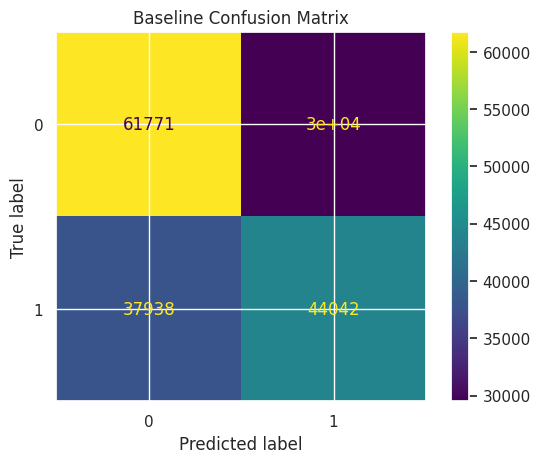

In [ ]:
# Measure memory and time before training
mem_before = psutil.Process().memory_info().rss / 1024 ** 2
start_time = time.time()

# Logistic Regression (timed)
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

train_time = time.time() - start_time
mem_after = psutil.Process().memory_info().rss / 1024 ** 2
mem_used = mem_after - mem_before

# Predict
y_pred = lr.predict(X_test_scaled)

# Metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Training time: {train_time:.4f} seconds")
print(f"Memory used: {mem_used:.2f} MB")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Baseline Confusion Matrix")
plt.show()


In [ ]:
import time
import psutil
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression as SparkLogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score

# Start Spark
spark = SparkSession.builder.appName("PersonalitySpark").getOrCreate()

# Convert train/test numpy arrays to pandas DataFrames
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)
y_train_df = pd.DataFrame(y_train.values, columns=["label"])
y_test_df = pd.DataFrame(y_test.values, columns=["label"])

# Combine features and label
train_pd = pd.concat([X_train_df, y_train_df], axis=1)
test_pd = pd.concat([X_test_df, y_test_df], axis=1)

# Convert to Spark DataFrames
train_spark = spark.createDataFrame(train_pd)
test_spark = spark.createDataFrame(test_pd)

# Vectorize features
features = list(X.columns)
assembler = VectorAssembler(inputCols=features, outputCol="features")
train_spark = assembler.transform(train_spark).select("features", "label")
test_spark = assembler.transform(test_spark).select("features", "label")

def train_and_log(train, test, label):
    lr = SparkLogisticRegression(featuresCol="features", labelCol="label", maxIter=100)
    mem_before = psutil.Process().memory_info().rss / 1024**2
    start = time.time()
    model = lr.fit(train)
    duration = time.time() - start
    mem_after = psutil.Process().memory_info().rss / 1024**2
    mem_used = mem_after - mem_before

    preds = model.transform(test)
    pred_pd = preds.select("label", "prediction").toPandas()
    cm = confusion_matrix(pred_pd['label'], pred_pd['prediction'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot()
    plt.title(f"Confusion Matrix: {label}")
    plt.show()

    acc = accuracy_score(pred_pd['label'], pred_pd['prediction'])
    f1 = f1_score(pred_pd['label'], pred_pd['prediction'])
    print(classification_report(pred_pd['label'], pred_pd['prediction']))

    return {
        "Setup": label,
        "F1 Score": round(f1, 4),
        "Accuracy": round(acc, 4),
        "Training Time (s)": round(duration, 4),
        "Memory Used (MB)": round(mem_used, 2)
    }

results = []
results.append(train_and_log(train_spark, test_spark, "Spark Default"))
results.append(train_and_log(train_spark.repartition(2), test_spark.repartition(2), "Spark 2 Partitions"))
results.append(train_and_log(train_spark.repartition(4), test_spark.repartition(4), "Spark 4 Partitions"))

pd.DataFrame(results)
